# ***先对一个文件进行verification


In [ ]:
import numpy as np
from Reader import gait_data_reader
from utilities import COMPARATOR
comparator1=COMPARATOR()
reader1=gait_data_reader()
import pandas as pd
info_dic={}
info=pd.read_excel('D:\\data\\DJO\\info.xlsx')
for i in range(len(info)):
    info_dic[info.loc[i,'编号']]=info.loc[i,'姓名']

In [ ]:
#读取所有的reference data
moment_list=reader1.get_data('joint_moment')
visit_list=reader1.get_name_week_list(moment_list,info_dic)

In [ ]:
IDgaitdata=reader1.read_motsto('C://Users//DX//Documents//OpenSim//4.4//Projects//KMP//ID//inverse_dynamics.sto')
print(IDgaitdata.name,IDgaitdata.week,IDgaitdata.count,IDgaitdata.category,IDgaitdata.data.shape)
ID_noadduction=reader1.read_motsto('C://Users//DX//Documents//OpenSim//4.4//Projects//KMP_version3//ID//inverse_dynamics.sto')
print(ID_noadduction.name,ID_noadduction.week,ID_noadduction.count,ID_noadduction.category,ID_noadduction.data.shape)

In [ ]:
# print(comparator1.get_rmse_cor(ID_noadduction,moment_list[0],73.5,1.7,'knee_angle_l_moment',1))
# print(comparator1.get_rmse_cor(ID_noadduction,moment_list[0],73.5,1.7,'knee_angle_r_moment',1))

print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'knee_flexion_l_moment',1))
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'knee_flexion_r_moment',1))
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'knee_adduction_l_moment',1))
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'knee_adduction_r_moment',1))

In [ ]:
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'ankle_angle_l_moment',1))
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'ankle_angle_r_moment',1))
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'subtalar_angle_r_moment',1))
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'subtalar_angle_l_moment',1))

In [ ]:
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'hip_flexion_l_moment',1))
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'hip_flexion_r_moment',1))
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'hip_adduction_l_moment',1))
print(comparator1.get_rmse_cor(IDgaitdata,moment_list[0],73.5,1.7,'hip_adduction_r_moment',1))

# ***对700个文件进行dynamics verify的前期准备工作


## 1.转化得到所有的trc和sto文件
下面代码是把所有的grf data 都转化为sto；c2d转化为trc是通过matlab实现的

grf_gaitdata_list=reader1.get_data('grf_exp')

def grf2sto(gait_data,sample_frequency):
    file_name=gait_data.name+'T'+str(gait_data.week)+'W'+str(gait_data.count)+'.sto'
    file_path='D:\\data\\dynamic\\grffile\\'+file_name
    
    data=gait_data.data
    category=gait_data.category
    nRow=data.shape[0]
    nColumns=data.shape[1]
    nCategories=len(category)
    grf_file=open(file_path,'w')
    grf_file.write('ground_reaction\n')
    grf_file.write('version=1\n')
    grf_file.write('nRows='+str(nRow)+'\n')
    grf_file.write('nColumns='+str(nColumns+1)+'\n')
    grf_file.write('inDegrees=no\n')
    grf_file.write('endheader\n')

    enheader='time\t ground_force_l_vx \t ground_force_l_vy \t ground_force_l_vz \t'
    enheader+= 'ground_force_l_px \t ground_force_l_py \t ground_force_l_pz \t'
    enheader+='ground_torque_l_x \t ground_torque_l_y \t ground_torque_l_z \t'
    enheader+='ground_force_r_vx \t ground_force_r_vy \t ground_force_r_vz \t'
    enheader+= 'ground_force_r_px \t ground_force_r_py \t ground_force_r_pz \t'
    enheader+='ground_torque_r_x \t ground_torque_r_y \t ground_torque_r_z \n'
    grf_file.write(enheader)
    change_axis_data=np.zeros((nRow,nColumns))
    new_data=np.zeros((nRow,nColumns))
    change_category_left_first=[0,2,4,1,3,5]
    change_category_right_first=[1,3,5,0,2,4]

    #先做坐标变换
    for i in range(nCategories):
        #和trc一致，绕着x轴旋转-90度，再绕着y轴旋转+90度
        change_axis_data[:,3*i]= - data[:,3*i+1]
        change_axis_data[:,3*i+1]=data[:,3*i+2]
        change_axis_data[:,3*i+2]= - data[:,3*i]

    #做category的变换
    #此时要判断先迈出左脚还是先迈出右脚，看FP1和FP2谁的z方向在
    FP1_pz=np.min(change_axis_data[:,8])
    FP2_pz=np.min(change_axis_data[:,11])
    if FP1_pz<FP2_pz:
        change_category_seq=change_category_left_first
    else:
        change_category_seq=change_category_right_first
    
    for i in range(6):
        ori_index=change_category_seq[i]
        new_data[:,3*i:3*i+3]=change_axis_data[:,ori_index*3:ori_index*3+3]
    delta=1/sample_frequency
    for time_index in range(nRow):
        toWrite = str(delta*(time_index))
        for angle_index in range(nColumns):
            toWrite += '\t' + str(new_data[time_index,angle_index])
        grf_file.write(toWrite + '\n')
    
    grf_file.close()
    print(file_name+' writing is finished')

for grf_gaitdata in grf_gaitdata_list:
    grf2sto(grf_gaitdata,1000)


In [4]:
## 2.从源文件中读取数据存入pkl文件
import numpy as np
import os
import shutil
from Reader import gait_data_reader
from utilities import COMPARATOR
import subprocess
import pandas as pd
import pickle

comparator1=COMPARATOR()
reader1=gait_data_reader()

# info_dic={}
# info=pd.read_excel('D:\\data\\dynamic\\info.xlsx')
# for i in range(len(info)):
#     info_dic[info.loc[i,'编号']]=info.loc[i,'姓名']
# pickle.dump(info_dic,open('info_dic.pkl','wb'))

injuryside_dic={}
info=pd.read_excel('D:\\data\\dynamic\\info.xlsx')
for i in range(len(info)):
    injuryside_dic[info.loc[i,'姓名']]=info.loc[i,'患侧']
pickle.dump(injuryside_dic,open('injuryside.pkl','wb'))

# BWHT_dic={}
# BWHT=pd.read_excel('D:\\data\\dynamic\\BWHT.xlsx')
# for i in range(len(BWHT)):
#     for t in range(4):
#         visit=BWHT.loc[i,'编号']+'T'+str(t+1)
#         mass=BWHT.loc[i,'T'+str(t+1)+'质量']
#         height=BWHT.loc[i,'T'+str(t+1)+'身高'] 
#         if np.isnan(mass):
#             pass
#         else:
#             BWHT_dic[visit]=(mass,height)
# pickle.dump(BWHT_dic,open('BWHT_dic.pkl','wb'))

#    #读取所有的reference data并存入pkl文件中
   
# moment_list=reader1.get_data('joint_moment')
# filename='all_moment.pkl'
# f=open(filename,'wb')
# pickle.dump(moment_list, f)

# ***dynamic verify PART


In [1]:
import numpy as np
import os
import shutil
from Reader import gait_data_reader
from utilities import COMPARATOR
import subprocess
import pandas as pd
import pickle
import xml.dom.minidom

comparator1=COMPARATOR()
reader1=gait_data_reader()

info_dic=pickle.load(open('info_dic.pkl','rb'))
BWHT_dic=pickle.load(open('BWHT_dic.pkl','rb'))
moment_list=pickle.load(open('all_moment.pkl','rb'))
print('load all_moment_data from pkl file')
print('\n','*'*50,'\n')

visit_list=reader1.get_name_week_list(moment_list,info_dic)


load all_moment_data from pkl file

 ************************************************** 

该部分数据中共有 20 位患者，平均每位患者有3.7次回访，共计74次,平均每次回访测试了9.85135135135135趟，共计729趟

 



In [ ]:
#对一个gaitdata进行model计算，并画出图像
def dynamic_model_verify(this_moment,plotornot,BWHT_dic,data_category_list):
    filename=this_moment.name + 'T'+ str(this_moment.week) + 'W' +str(this_moment.count)
    visit=this_moment.name + 'T'+ str(this_moment.week)

    print('Begin the dynamics model calculation of No. {} test '.format(filename))
    grf_src=r'D:\\data\\dynamic\\grffile\\{}.sto'.format(filename)
    grf_dst=r'C:\\Users\\DX\\Documents\\OpenSim\\4.4\\Projects\\KMP\\exp_data\\grf.sto'
    trc_src=r'D:\\data\\dynamic\\trcfile\\{}.trc'.format(filename)
    trc_dst=r'C:\\Users\\DX\\Documents\\OpenSim\\4.4\\Projects\\KMP\\exp_data\\motion.trc'

    if os.path.exists(grf_src)  and os.path.exists(trc_src):
        print('copying the trc and grf file to the opensim folder........')
        shutil.copy(grf_src,grf_dst)
        shutil.copy(trc_src,trc_dst)
        mass=BWHT_dic[visit][0]
        height=BWHT_dic[visit][1]

        print('scaling the model........')
        scale_setup_path=r'C:/Users/DX/Documents/OpenSim/4.4/Projects/KMP/scale_Setup.xml'
        #首先将mass写入scale setup文件当中
        dom = xml.dom.minidom.parse(scale_setup_path) 
        root = dom.documentElement 
        scale_mass = root.getElementsByTagName("mass")
        scale_mass[0].firstChild.data=mass
        with open(scale_setup_path, 'w',encoding='utf-8') as f:
            dom.writexml(f, addindent='  ', encoding='utf-8')
        
        subprocess.run(r'scale -S C:/Users/DX/Documents/OpenSim/4.4/Projects/KMP/scale_Setup.xml', capture_output=True, text=True)

        print('calculating the inverse kinematics of this trc........')
        if os.system(r'ik -S C:/Users/DX/Documents/OpenSim/4.4/Projects/KMP/ik_Setup.xml')!=0:
            raise RuntimeError('IK tools have runnning ERROR')
        
        print('calculating the inverse dynamics of this gait........')
        if os.system(r'id -S C:/Users/DX/Documents/OpenSim/4.4/Projects/KMP/id_Setup.xml')!=0:
            raise RuntimeError('ID tools have runnning ERROR')
        
        IDgaitdata=reader1.read_motsto('C://Users//DX//Documents//OpenSim//4.4//Projects//KMP//ID//inverse_dynamics.sto')
        print('copying the ik_output+id_output file to the dataset........')
        ik_output_src=r'C:/Users/DX/Documents/OpenSim/4.4/Projects/KMP/IK_output/ik_output.mot'
        ik_output_dst=r'D:\\data\\dynamic\\motfile\\{}.mot'.format(filename)
        shutil.copy(ik_output_src,ik_output_dst)
        id_output_src=r'C:/Users/DX/Documents/OpenSim/4.4/Projects/KMP/ID/inverse_dynamics.sto'
        id_output_dst=r'D:\\data\\dynamic\\idfile\\{}.sto'.format(filename)
        shutil.copy(id_output_src,id_output_dst)

        print('Calculation is done! ')
        #如何获得每一个visit患者的质量和身高（还是要用dic）

        nrmse_list=[]
        rmse_list=[]
        corr_list=[]

        #目前是只对knee_flexion_r_moment做了分析，应该要对所有的data_category都做分析
        for data_category in data_category_list:
            nrmse, rmse, corr=comparator1.get_nrmse_rmse_cor(IDgaitdata,this_moment,mass,height,data_category,plotornot)
            print('NRMSE, RMSE and correlation coefficient of {} between the computed moment and the reference is {} , {} and {}'.format(data_category,nrmse,rmse,corr))
            nrmse_list.append(nrmse)
            rmse_list.append(rmse)
            corr_list.append(corr)

        print('\n','*'*50,'\n')
        return nrmse_list,rmse_list,corr_list

    else:
        print('there is NO such trc/sto file of this test!')
        print('\n','*'*50,'\n')
        return [-1],[-1],[0]
j=60
all_data_category=['hip_flexion_l_moment','hip_flexion_r_moment','hip_adduction_l_moment','hip_adduction_r_moment',
                    'knee_flexion_l_moment','knee_flexion_r_moment','knee_adduction_l_moment','knee_adduction_r_moment',
                    'ankle_angle_l_moment','ankle_angle_r_moment','subtalar_angle_l_moment','subtalar_angle_r_moment']
dynamic_model_verify(moment_list[j],1,BWHT_dic,all_data_category)


In [ ]:
#对所有的moment都进行计算！
all_data_category=['hip_flexion_l_moment','hip_flexion_r_moment','hip_adduction_l_moment','hip_adduction_r_moment',
                    'knee_flexion_l_moment','knee_flexion_r_moment','knee_adduction_l_moment','knee_adduction_r_moment',
                    'ankle_angle_l_moment','ankle_angle_r_moment','subtalar_angle_l_moment','subtalar_angle_r_moment']
all_nrmse=[]
all_rmse=[]
all_corr=[]

for moment in moment_list:
    nrmse_list,rmse_list,corr_list=dynamic_model_verify(moment,0,BWHT_dic,all_data_category)
    all_nrmse.append(nrmse_list)
    all_rmse.append(rmse_list)
    all_corr.append(corr_list)

    

# 分析verify result
verify的过程在服务器上跑完了，下面分析verify得到的结果

In [1]:
import numpy as np
import os
import shutil
from Reader import gait_data_reader
from utilities import COMPARATOR
import subprocess
import pandas as pd
import pickle
import xml.dom.minidom
import matplotlib.pyplot as plt
comparator1=COMPARATOR()
reader1=gait_data_reader()

info_dic=pickle.load(open('info_dic.pkl','rb'))
BWHT_dic=pickle.load(open('BWHT_dic.pkl','rb'))
moment_list=pickle.load(open('all_moment.pkl','rb'))


all_nrmse=pickle.load(open('../Dynamics_model/verif_result/all_nrmse.pkl','rb'))
all_corr=pickle.load(open('../Dynamics_model/verif_result/all_corr.pkl','rb'))
all_rmse=pickle.load(open('../Dynamics_model/verif_result/all_rmse.pkl','rb'))
print(len(all_rmse),len(all_corr),len(all_nrmse))

729 729 729


D1M07T1W4


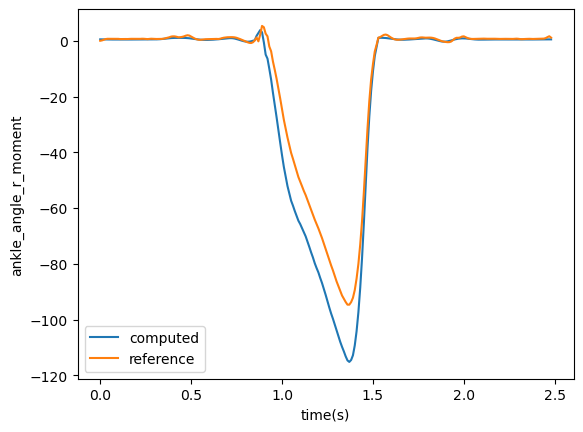

(0.07689750430435474, 7.687347114284697, 0.9973620468547424)

In [6]:
j=0
this_moment=moment_list[j]
filename=this_moment.name + 'T'+ str(this_moment.week) + 'W' +str(this_moment.count)
print(filename)
visit=this_moment.name + 'T'+ str(this_moment.week)
mass=BWHT_dic[visit][0]
height=BWHT_dic[visit][1]
ID=reader1.read_motsto(r'D:\\data\\dynamic\\idfile\\{}.sto'.format(filename))
comparator1.get_nrmse_rmse_cor(ID,this_moment,mass,height,'ankle_angle_r_moment',1)

In [34]:
valid_nrmse=[]
for i in range(len(all_nrmse)):
    if len(all_nrmse[i])!=12:
        # print(all_nrmse[i])
        pass
    else:
        valid_nrmse.append(all_nrmse[i])
nrmse=np.array(valid_nrmse,dtype=object)
print(nrmse.shape)

valid_rmse=[]
for i in range(len(all_rmse)):
    if len(all_rmse[i])!=12:
        # print(all_nrmse[i])
        pass
    else:
        valid_rmse.append(all_rmse[i])
rmse=np.array(valid_rmse,dtype=object)
print(rmse.shape)


valid_corr=[]
for i in range(len(all_corr)):
    if len(all_corr[i])!=12:
        # print(all_nrmse[i])
        pass
    else:
        valid_corr.append(all_corr[i])
corr=np.array(valid_corr,dtype=np.float32)
print(corr.shape)

(713, 12)
(713, 12)
(713, 12)


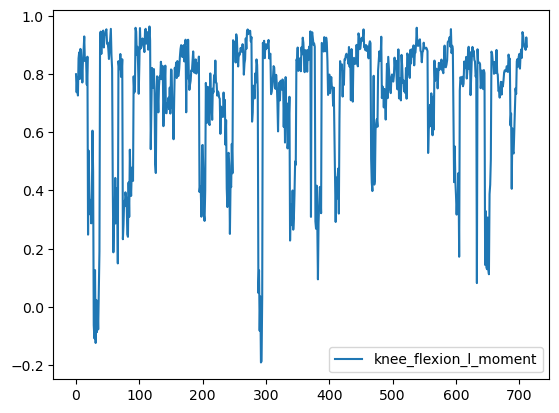

In [35]:
all_data_category=['hip_flexion_l_moment','hip_flexion_r_moment','hip_adduction_l_moment','hip_adduction_r_moment',
                    'knee_flexion_l_moment','knee_flexion_r_moment','knee_adduction_l_moment','knee_adduction_r_moment',
                    'ankle_angle_l_moment','ankle_angle_r_moment','subtalar_angle_l_moment','subtalar_angle_r_moment']

j=4
plt.plot(corr[:,j],label=all_data_category[j])
plt.legend()
plt.show()



In [46]:
import math
nrmse_aver=np.average(nrmse,axis=0)
corr_aver=np.average(corr,axis=0)
rmse_aver=np.average(rmse,axis=0)
nrmse_var=np.var(nrmse,axis=0)
corr_var=np.var(corr,axis=0)
rmse_var=np.var(rmse,axis=0)
nrmse_std=[]
rmse_std=[]
corr_std=[]

for i in range(12):
    nrmse_std.append(math.sqrt(nrmse_var[i]))
    rmse_std.append(math.sqrt(rmse_var[i]))
    corr_std.append(math.sqrt(corr_var[i]))



print(nrmse_aver[4:8],'\n'*2,corr_aver[4:8],'\n'*2,rmse_aver[4:8])
print('\n'*4)
print(nrmse_std[4:8],'\n'*2,corr_std[4:8],'\n'*2,rmse_std[4:8])


[0.21666376238281126 0.2020140903393901 0.12775648826747482
 0.15011441769969802] 

 [0.72530895 0.7644082  0.9428485  0.9188596 ] 

 [14.524843600177826 14.255220532313183 5.742977984156343 6.018332690086687]





[0.12424669453916365, 0.10325350239928291, 0.0824339970633855, 0.07102103777031665] 

 [0.21998195640577783, 0.15201364724049657, 0.07471509341450856, 0.08144312588068572] 

 [6.314157959171821, 5.513047870650207, 4.250976997048092, 4.486004058298045]
